In [ ]:
### Load libraries ###
# from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Reshape, Conv2DTranspose, UpSampling2D
from keras.models import Model
import os
import numpy as np
from PIL import Image
from PIL import ImageFile
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
import random


In [ ]:
# Define paths to the training data
TRAINING_PATH   = '/content/drive/MyDrive/NeuralNetworks/Project/sets/training'
VALIDATION_PATH = '/content/drive/MyDrive/NeuralNetworks/Project/sets/validation'
TEST_PATH       = '/content/drive/MyDrive/NeuralNetworks/Project/sets/test'

In [ ]:
# Encoder
class Encoder(nn.Module):
    def __init__(self, input_shape, encoded_dim):
        super().__init__()
        channels, height, width = input_shape
        
        self.conv1 = nn.Conv2d(channels, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc = nn.Linear(128 * (height//8) * (width//8), encoded_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [ ]:
# Decoder class

class Decoder(nn.Module):
    def __init__(self, encoded_dim, output_shape):
        super().__init__()
        self.fc1 = nn.Linear(encoded_dim, 256 * 16 * 16)
        self.conv1 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        x = self.fc1(x)
        x = x.view(-1, 256, 16, 16)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = torch.sigmoid(self.conv4(x))
        x = F.interpolate(x, size=(512,512), mode='bilinear', align_corners=False)
        return x


In [ ]:
# Define train, validation, and test sets
training_files = sorted(os.listdir(TRAINING_PATH))
training_files_midpoint = int(len(training_files)/4)
train_data = [('noisy_'+file, file) for file in training_files[:training_files_midpoint]]

print(len(train_data))

validation_files = sorted(os.listdir(VALIDATION_PATH))
validation_files_midpoint = int(len(validation_files)/4)
validation_data = [('noisy_'+file, file) for file in validation_files[:validation_files_midpoint]]

print(len(validation_data))

test_files = sorted(os.listdir(TEST_PATH))
test_files_midpoint = int(len(test_files)/4)
test_data = [('noisy_'+file, file) for file in test_files[:test_files_midpoint]]

print(len(test_data))

1800
600
600


In [ ]:
# Define data transformation (just converting to tensor for now)
data_transform = transforms.Compose([
        transforms.ToTensor()
    ])

In [ ]:
# Define a dataloader
class DenoiseDataset(torch.utils.data.Dataset):
    def __init__(self, data_list, path, transform=None):
        self.data_list = data_list
        self.transform = transform
        self.path = path

    def __getitem__(self, index):
        noisy_file, clean_file = self.data_list[index]
        noisy_img = Image.open(os.path.join(self.path, noisy_file))
        clean_img = Image.open(os.path.join(self.path, clean_file))
        noisy_tensor = self.transform(noisy_img)
        clean_tensor = self.transform(clean_img)
        return {'noisy': noisy_tensor, 'clean': clean_tensor}

    def __len__(self):
        return len(self.data_list)


In [ ]:
# Load data for each dataset
train_dataset = DenoiseDataset(train_data, path=TRAINING_PATH, transform=data_transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)

validation_dataset = DenoiseDataset(validation_data, path=VALIDATION_PATH, transform=data_transform)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=1, shuffle=True)

test_dataset = DenoiseDataset(test_data, path=TEST_PATH, transform=data_transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

In [ ]:
# Define the device to be used for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

my_best_model = "/content/drive/MyDrive/NeuralNetworks/best_model.pth"

In [ ]:
# Define your denoising autoencoder model
class DenoisingAutoencoder(nn.Module):
    def __init__(self, input_shape, encoded_dim):
        super().__init__()
        self.encoder = Encoder(input_shape, encoded_dim)
        self.decoder = Decoder(encoded_dim, input_shape)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Define the input/output (they're symmetrical) shape and encoded dimension
input_shape = (1, 512, 512)
encoded_dim = 64

# Define encoder and decoder models as PyTorch modules
encoder = Encoder(input_shape=input_shape, encoded_dim=encoded_dim)
decoder = Decoder(encoded_dim=encoded_dim, output_shape=input_shape)

# Create an instance of the DenoisingAutoencoder model
model = DenoisingAutoencoder(input_shape=input_shape, encoded_dim=encoded_dim)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# Train the model
num_epochs = 5
best_loss = float('inf')

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, batch in tqdm(enumerate(train_loader, 0)):

        inputs, targets = batch['noisy'], batch['clean']
        
        inputs_data = inputs.to(device)
        targets_data = targets.to(device)

        optimizer.zero_grad()

        outputs = model(inputs_data)
        
        loss = criterion(outputs, targets_data)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 100 == 99:
            print(f'[{epoch+1}, {i+1}] loss: {running_loss/100}')
            running_loss = 0.0

    # Evaluate the model on the validation set and save the best model
    val_loss = 0.0
    with torch.no_grad():
        for data in validation_loader:
            inputs, targets = data['noisy'], data['clean']
            inputs_data = inputs.to(device)
            targets_data = targets.to(device)
            outputs = model(inputs_data)
            val_loss += criterion(outputs, targets_data).item()

    val_loss /= len(validation_loader)
    print('Validation loss: %.3f' % val_loss)

    if val_loss < best_loss:
        print('Saving model state...')
        torch.save(model.state_dict(), my_best_model)
        best_loss = val_loss

print('Finished training.')


23it [00:46,  1.91s/it]/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 4, 512, 512])) that is different to the input size (torch.Size([1, 1, 512, 512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100it [03:22,  2.04s/it]

[1, 100] loss: 0.04866583268158138


200it [06:34,  1.87s/it]

[1, 200] loss: 0.033711762027814986


300it [09:49,  2.00s/it]

[1, 300] loss: 0.026005547689273954


400it [13:11,  2.24s/it]

[1, 400] loss: 0.021628693398088216


500it [16:25,  1.92s/it]

[1, 500] loss: 0.018903119075112045


600it [19:42,  2.19s/it]

[1, 600] loss: 0.0175606380822137


700it [23:35,  2.40s/it]

[1, 700] loss: 0.016079862266778946


800it [27:29,  2.11s/it]

[1, 800] loss: 0.016644945931620896


900it [31:13,  2.23s/it]

[1, 900] loss: 0.01443642100552097


1000it [35:01,  2.20s/it]

[1, 1000] loss: 0.014933602837845682


1100it [38:47,  2.27s/it]

[1, 1100] loss: 0.01508091608993709


1200it [42:33,  2.21s/it]

[1, 1200] loss: 0.014850337542593479


1300it [46:27,  2.19s/it]

[1, 1300] loss: 0.013409307724796236


1400it [50:14,  2.29s/it]

[1, 1400] loss: 0.016770283421501518


1500it [54:11,  2.26s/it]

[1, 1500] loss: 0.014509808304719627


1600it [58:01,  2.29s/it]

[1, 1600] loss: 0.011522051955107599


1700it [1:01:50,  2.25s/it]

[1, 1700] loss: 0.01158424916677177


1800it [1:05:40,  2.19s/it]

[1, 1800] loss: 0.010968255084007979


Validation loss: 0.013
Saving model state...


100it [02:44,  1.61s/it]

[2, 100] loss: 0.01259927801322192


200it [05:16,  1.47s/it]

[2, 200] loss: 0.010557552222162486


300it [07:48,  1.47s/it]

[2, 300] loss: 0.009974343259818852


400it [10:21,  1.54s/it]

[2, 400] loss: 0.009594818567857146


500it [12:53,  1.68s/it]

[2, 500] loss: 0.010818734574131668


600it [15:24,  1.41s/it]

[2, 600] loss: 0.010889005220960826


700it [17:57,  1.44s/it]

[2, 700] loss: 0.009841977576725185


800it [20:28,  1.53s/it]

[2, 800] loss: 0.008905754275619984


900it [22:57,  1.46s/it]

[2, 900] loss: 0.009533856983762235


1000it [25:27,  1.45s/it]

[2, 1000] loss: 0.009623669860884547


1100it [28:07,  1.45s/it]

[2, 1100] loss: 0.009801061376929283


1200it [30:40,  1.47s/it]

[2, 1200] loss: 0.010683329179883003


1300it [33:13,  1.55s/it]

[2, 1300] loss: 0.009894156905356794


1400it [35:46,  1.69s/it]

[2, 1400] loss: 0.00930835509672761


1500it [38:25,  1.63s/it]

[2, 1500] loss: 0.007354160542599857


1600it [40:55,  1.41s/it]

[2, 1600] loss: 0.009222749432083219


1700it [43:25,  1.46s/it]

[2, 1700] loss: 0.008160560363903642


1800it [45:55,  1.53s/it]

[2, 1800] loss: 0.008007163973525166


Validation loss: 0.008
Saving model state...


100it [02:29,  1.67s/it]

[3, 100] loss: 0.006525667693931609


200it [05:00,  1.46s/it]

[3, 200] loss: 0.007497576999012381


300it [07:31,  1.44s/it]

[3, 300] loss: 0.008182820528745652


400it [10:00,  1.62s/it]

[3, 400] loss: 0.006834399229846895


500it [12:29,  1.41s/it]

[3, 500] loss: 0.009203563046175986


600it [14:57,  1.50s/it]

[3, 600] loss: 0.009756183202844113


700it [17:33,  1.77s/it]

[3, 700] loss: 0.007794332208577543


800it [20:04,  1.60s/it]

[3, 800] loss: 0.006902938764542341


900it [22:36,  1.44s/it]

[3, 900] loss: 0.007888782387599349


1000it [25:09,  1.47s/it]

[3, 1000] loss: 0.00930623521329835


1100it [27:47,  1.52s/it]

[3, 1100] loss: 0.006354902551975101


1200it [30:19,  1.43s/it]

[3, 1200] loss: 0.009221633521374315


1300it [32:50,  1.47s/it]

[3, 1300] loss: 0.007846947975922376


1400it [35:20,  1.64s/it]

[3, 1400] loss: 0.006857143563684076


1500it [37:59,  1.62s/it]

[3, 1500] loss: 0.006269259639084339


1600it [40:31,  1.66s/it]

[3, 1600] loss: 0.007227495333645493


1700it [43:03,  1.54s/it]

[3, 1700] loss: 0.006567926169373095


1800it [45:34,  1.52s/it]

[3, 1800] loss: 0.0057671942852903155


Validation loss: 0.007
Saving model state...


100it [02:30,  1.66s/it]

[4, 100] loss: 0.005465714244637638


200it [04:57,  1.43s/it]

[4, 200] loss: 0.007216062447987497


300it [07:27,  1.59s/it]

[4, 300] loss: 0.008906772134359926


400it [09:56,  1.40s/it]

[4, 400] loss: 0.00672537115169689


500it [12:25,  1.48s/it]

[4, 500] loss: 0.00744684555567801


600it [14:56,  1.67s/it]

[4, 600] loss: 0.006758422872517258


700it [17:33,  1.69s/it]

[4, 700] loss: 0.006868434082716704


800it [20:04,  1.47s/it]

[4, 800] loss: 0.006276993703795597


900it [22:35,  1.43s/it]

[4, 900] loss: 0.00679958073887974


1000it [25:10,  1.45s/it]

[4, 1000] loss: 0.006773416099604219


1100it [27:48,  1.43s/it]

[4, 1100] loss: 0.0064548160647973415


1200it [30:21,  1.47s/it]

[4, 1200] loss: 0.006861145333386958


1300it [32:55,  1.50s/it]

[4, 1300] loss: 0.006302536997245625


1400it [35:28,  1.51s/it]

[4, 1400] loss: 0.006653027958236635


1500it [38:09,  1.47s/it]

[4, 1500] loss: 0.00600447628996335


1600it [40:44,  1.44s/it]

[4, 1600] loss: 0.0078114192048087715


1700it [43:18,  1.47s/it]

[4, 1700] loss: 0.006639618454501033


1800it [45:53,  1.53s/it]

[4, 1800] loss: 0.0057808779296465215


Validation loss: 0.007


100it [02:32,  1.44s/it]

[5, 100] loss: 0.006288994981441647


200it [05:04,  1.47s/it]

[5, 200] loss: 0.005869287438690663


300it [07:36,  1.51s/it]

[5, 300] loss: 0.005667370993178338


400it [10:17,  1.46s/it]

[5, 400] loss: 0.00651495382655412


500it [12:50,  1.45s/it]

[5, 500] loss: 0.005999319422990083


600it [15:26,  1.46s/it]

[5, 600] loss: 0.0059178611822426315


700it [18:00,  1.45s/it]

[5, 700] loss: 0.005194941683439538


800it [20:33,  1.51s/it]

[5, 800] loss: 0.006572313182987273


900it [23:07,  1.52s/it]

[5, 900] loss: 0.004619200051529333


1000it [25:39,  1.55s/it]

[5, 1000] loss: 0.006383404566440732


1100it [28:13,  1.63s/it]

[5, 1100] loss: 0.004809260834008455


1200it [30:43,  1.50s/it]

[5, 1200] loss: 0.008199772147927433


1300it [33:14,  1.43s/it]

[5, 1300] loss: 0.006560161749366671


1400it [35:45,  1.52s/it]

[5, 1400] loss: 0.006359847865533084


1500it [38:24,  1.47s/it]

[5, 1500] loss: 0.007291274755261839


1600it [41:00,  1.45s/it]

[5, 1600] loss: 0.006896869618212804


1700it [43:31,  1.50s/it]

[5, 1700] loss: 0.004838906810618937


1800it [46:05,  1.54s/it]

[5, 1800] loss: 0.005278926562750712


Validation loss: 0.006
Saving model state...
Finished training.


In [ ]:
# Testing

# Load the best model
model.load_state_dict(torch.load(my_best_model))

# Switch to eval mode
model.eval()

# Test the model on the test dataset
test_loss = 0.0
with torch.no_grad():
    for data in tqdm(test_loader):
        inputs, targets = data['noisy'], data['clean']
        inputs_data = inputs.to(device)
        targets_data = targets.to(device)
        outputs = model(inputs_data)
        test_loss += criterion(outputs, targets_data).item()

test_loss /= len(test_loader)
print('Test loss: %.3f' % test_loss)


 11%|█         | 67/600 [00:22<02:12,  4.03it/s]/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 4, 512, 512])) that is different to the input size (torch.Size([1, 1, 512, 512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 600/600 [02:52<00:00,  3.48it/s]

Test loss: 0.006


In [ ]:
# Function to test out the model's ability to reconstruct the images
def show_test_model(clean_image, noisy_image):
    # Load the model from the saved state dict
    model.load_state_dict(torch.load(my_best_model))
    model.eval()

    # Load the clean and noisy images from the filenames
    clean_image_data = Image.open(clean_image).convert('L')
    noisy_image_data = Image.open(noisy_image).convert('L')

    # Apply the image transforms and add a batch dimension to the noisy image
    clean_image_tensor = data_transform(clean_image_data).unsqueeze(0).to(device)
    noisy_image_tensor = data_transform(noisy_image_data).unsqueeze(0).to(device)

    # Run the noisy image through the model to get the cleaned image
    cleaned_image_tensor = model(noisy_image_tensor)

    # Convert the tensors to PIL images and display them
    clean_image_pil = transforms.ToPILImage()(clean_image_tensor.squeeze().cpu())
    noisy_image_pil = transforms.ToPILImage()(noisy_image_tensor.squeeze().cpu())
    cleaned_image_pil = transforms.ToPILImage()(cleaned_image_tensor.squeeze().cpu())

    # Show the images with their titles
    fig, axs = plt.subplots(1, 3, figsize=(10, 5))
    axs[0].imshow(clean_image_pil, cmap='gray')
    axs[0].set_title('Clean image')
    axs[1].imshow(noisy_image_pil, cmap='gray')
    axs[1].set_title('Noisy image')
    axs[2].imshow(cleaned_image_pil, cmap='gray')
    axs[2].set_title('Cleaned image')
    plt.show()

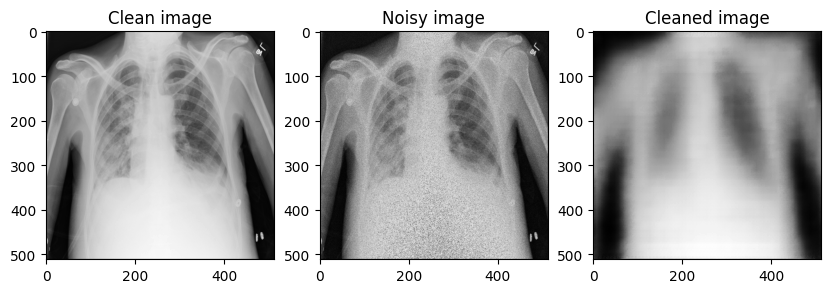

In [ ]:
# Show examples of how well the model denoises test data

test_data_len = len(test_data)
rand_idx = random.randint(0, test_data_len-1)
noisy_image, clean_image = test_data[rand_idx]
noisy_path = os.path.join(TEST_PATH, noisy_image)
clean_path = os.path.join(TEST_PATH, clean_image)
show_test_model(clean_image=clean_path, noisy_image=noisy_path)


In [ ]:
### Add your image paths and run this block to test out your own! ###
clean_image_path = ""
noisy_image_path = ""
show_test_model(clean_image=clean_image_path, noisy_image=noisy_image_path)
